In [8]:
from IPython.display import Image
from imutils import paths
import numpy as np
import cv2
import os

In [7]:
!pip install --upgrade pip
!pip install imutils
!pip install opencv-python
!pip install --upgrade scikit-learn==0.23.0

Requirement already up-to-date: pip in ./anaconda3/lib/python3.7/site-packages (20.1.1)
  Using cached scikit_learn-0.23.0-cp37-cp37m-manylinux1_x86_64.whl (7.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1


In [9]:
for dir, subdirs, files in os.walk('train'):
            for f in files:
              print(f)

cat.101.jpg
dog.75.jpg
cat.351.jpg
dog.243.jpg
cat.181.jpg
dog.174.jpg
cat.84.jpg
dog.249.jpg
cat.283.jpg
dog.449.jpg
dog.222.jpg
dog.300.jpg
dog.411.jpg
cat.260.jpg
cat.31.jpg
cat.59.jpg
cat.497.jpg
cat.410.jpg
dog.58.jpg
cat.113.jpg
cat.175.jpg
dog.396.jpg
dog.436.jpg
dog.281.jpg
dog.259.jpg
cat.40.jpg
cat.149.jpg
dog.146.jpg
cat.50.jpg
cat.187.jpg
cat.262.jpg
cat.176.jpg
dog.221.jpg
dog.387.jpg
dog.433.jpg
cat.292.jpg
dog.330.jpg
dog.218.jpg
dog.363.jpg
cat.462.jpg
cat.456.jpg
dog.393.jpg
cat.458.jpg
dog.339.jpg
cat.126.jpg
dog.354.jpg
cat.225.jpg
dog.349.jpg
cat.397.jpg
cat.189.jpg
cat.364.jpg
dog.440.jpg
cat.186.jpg
cat.337.jpg
cat.151.jpg
cat.139.jpg
dog.6.jpg
dog.186.jpg
dog.124.jpg
cat.12.jpg
cat.381.jpg
cat.81.jpg
dog.448.jpg
cat.15.jpg
dog.364.jpg
dog.211.jpg
cat.450.jpg
dog.350.jpg
dog.76.jpg
dog.159.jpg
cat.389.jpg
cat.198.jpg
dog.224.jpg
cat.282.jpg
dog.275.jpg
dog.326.jpg
cat.75.jpg
cat.164.jpg
cat.398.jpg
cat.103.jpg
dog.328.jpg
cat.61.jpg
dog.289.jpg
cat.67.jpg
cat.249.

Для работы с изображениями, найдем их гистограммы — характеристики распределения интенсивности изображения. Для этого можно воспользоваться следующим методом.

In [10]:
def extract_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

Считаем изображения из корневой папки train и вычислим гистограмму каждого изображения. Кроме того, отделим метку каждого изображения. Обработка большого числа изображений в облачных сервисах занимает длительное время (1-5 минут).

In [11]:
imagePaths = sorted(list(paths.list_images('train')))
trainData = []
labels = []

for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath, 1)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    hist = extract_histogram(image)
    trainData.append(hist)
    labels.append(label)

Преобразуем метки в удобный формат 0 и 1. Cat заменяем на 1, Dog на 0.

In [12]:
Y = [1 if x == 'cat' else 0 for x in labels]

1


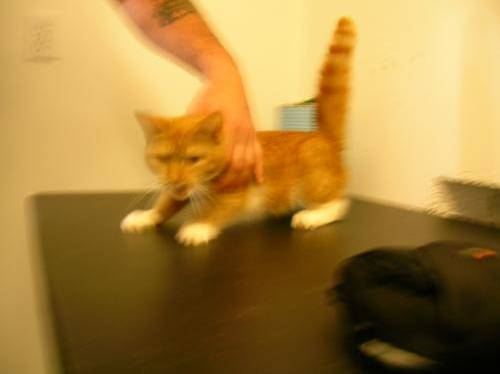

In [13]:
print(Y[0])
Image(filename=imagePaths[0])

Видно, что классом 1 у нас занумерованы коты (кошки).

Обучаем первый базовый классификатор - бэггинг деревьев принятия решений

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', #критерий разделения
                              min_samples_leaf=10, #минимальное число объектов в листе
                              max_leaf_nodes=20, #максимальное число листьев
                              random_state=462)
bagging = BaggingClassifier(tree, #базовый алгоритм
                            n_estimators=19, #количество деревьев
                            random_state=462)
bagging.fit(trainData, Y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_leaf_nodes=20,
                                                        min_samples_leaf=10,
                                                        random_state=462),
                  n_estimators=19, random_state=462)

Теперь обучим модель почти-разделяющий гиперплосоксти.

In [15]:
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state = 462, C = 1.09)
svm.fit(trainData, Y)

LinearSVC(C=1.09, random_state=462)

И наконец обучаем третий базовый алгоритм — случайный лес

In [16]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=19, #количество деревьев
                             criterion='entropy', #критерий разделения
                              min_samples_leaf=10, #минимальное число объектов в листе
                              max_leaf_nodes=20, #максимальное число листьев
                              random_state=462)
forest.fit(trainData, Y)

RandomForestClassifier(criterion='entropy', max_leaf_nodes=20,
                       min_samples_leaf=10, n_estimators=19, random_state=462)

Задаем в качестве решающего метаалгоритма логистическую регрессию:

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', random_state=462)

Обучаем метаалгоритм

In [18]:
from sklearn.ensemble import StackingClassifier

base_estimators = [('SVM', svm), ('Bagging DT', bagging), ('DecisionForest', forest)]
sclf = StackingClassifier(estimators=base_estimators, final_estimator=lr, cv=2)
sclf.fit(trainData, Y)

StackingClassifier(cv=2,
                   estimators=[('SVM', LinearSVC(C=1.09, random_state=462)),
                               ('Bagging DT',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                        max_leaf_nodes=20,
                                                                                        min_samples_leaf=10,
                                                                                        random_state=462),
                                                  n_estimators=19,
                                                  random_state=462)),
                               ('DecisionForest',
                                RandomForestClassifier(criterion='entropy',
                                                       max_leaf_nodes=20,
                                                       min_samples_leaf=10,
       

Оценка метамодели. Доля правильной классификации (Accuracy):

In [19]:
sclf.score(trainData, Y)

0.839

Вычислим предсказания для объекта из папки test

In [38]:
singleImage = cv2.imread('test/cat.1004.jpg')
histt = extract_histogram(singleImage)
histt2 = histt.reshape(1, -1)
prediction = sclf.predict(histt2)

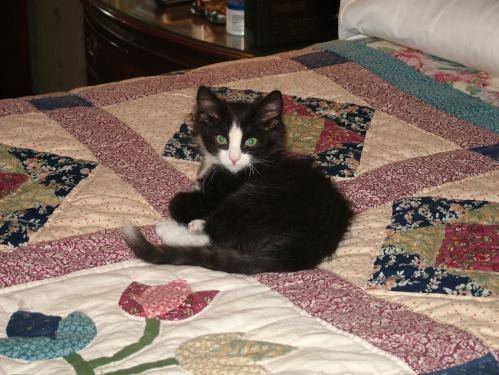

In [39]:
Image(filename='test/cat.1004.jpg')

In [40]:
prediction

array([0])

In [41]:
sclf.predict_proba(histt2)

array([[0.58395807, 0.41604193]])

Видно, что построенный классификатор успешно справился с заданием.